# Task L23

## Import the required libraries

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Load dataset

In [20]:
df = pd.read_csv("electricity_consumption_and_production.csv")
df['DateTime'] = pd.to_datetime(df['DateTime'])
df.set_index('DateTime', inplace=True)
df = df.sort_index()

# Resample to daily sum and drop NaN

In [21]:
daily_df = df['Consumption'].resample('D').sum().to_frame()
daily_df.dropna(inplace=True)

# Print last 50 daily values to check for NaNs or issues

In [22]:
print("\nLast 50 days of daily_df:")
print(daily_df.tail(50))


Last 50 days of daily_df:
            Consumption
DateTime               
2025-01-29       162872
2025-01-30       162461
2025-01-31       153063
2025-02-01       105572
2025-02-02       102060
2025-02-03       171615
2025-02-04       175076
2025-02-05       177993
2025-02-06       176311
2025-02-07       153045
2025-02-08       123941
2025-02-09       147404
2025-02-10       155349
2025-02-11       159098
2025-02-12        61192
2025-02-13            0
2025-02-14            0
2025-02-15        13140
2025-02-16       156299
2025-02-17       157554
2025-02-18       186606
2025-02-19       166129
2025-02-20       147732
2025-02-21       130906
2025-02-22       163337
2025-02-23       126109
2025-02-24       157997
2025-02-25       121793
2025-02-26       171564
2025-02-27       174298
2025-02-28       161031
2025-03-01       161932
2025-03-02       144388
2025-03-03       158728
2025-03-04       158022
2025-03-05       150201
2025-03-06       151398
2025-03-07       150195
2025-03-08   

# Forecast horizon (days ahead)

In [23]:
forecast_days = [15, 30, 45]

# --- SARIMAX MODEL ---

In [24]:
results_sarimax = {}
for horizon in forecast_days:
    sarimax_model = SARIMAX(daily_df, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
    sarimax_fit = sarimax_model.fit(disp=False)
    pred = sarimax_fit.forecast(steps=horizon)
    pred.index = pd.date_range(start=daily_df.index[-1] + pd.Timedelta(days=1), periods=horizon)
    results_sarimax[horizon] = pred

# --- Prophet MODEL ---

In [25]:
prophet_df = daily_df.reset_index().rename(columns={'DateTime': 'ds', 'Consumption': 'y'})
model_prophet = Prophet(daily_seasonality=True)
model_prophet.fit(prophet_df)
future = model_prophet.make_future_dataframe(periods=max(forecast_days))
forecast = model_prophet.predict(future)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcurrwoql/32r1_vb_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcurrwoql/pt6ngt2_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53013', 'data', 'file=/tmp/tmpcurrwoql/32r1_vb_.json', 'init=/tmp/tmpcurrwoql/pt6ngt2_.json', 'output', 'file=/tmp/tmpcurrwoql/prophet_modelj1wmb3oz/prophet_model-20250628152621.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:26:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:26:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


# Extract Prophet results

In [26]:
results_prophet = {}
for horizon in forecast_days:
    prediction = forecast[['ds', 'yhat']].set_index('ds')[-horizon:]['yhat']
    prediction.index = pd.date_range(start=daily_df.index[-1] + pd.Timedelta(days=1), periods=horizon)
    results_prophet[horizon] = prediction

# --- Time-Lagged Regression MODEL ---

In [27]:
lagged_df = daily_df.copy()
for lag in range(1, 8):
    lagged_df[f'lag_{lag}'] = lagged_df['Consumption'].shift(lag)
lagged_df.dropna(inplace=True)

X = lagged_df.drop('Consumption', axis=1)
y = lagged_df['Consumption']
model_lr = LinearRegression().fit(X, y)

results_lr = {}
last_data = lagged_df.iloc[-1, 1:].values.reshape(1, -1)
for horizon in forecast_days:
    preds = []
    current_input = last_data.copy()
    for _ in range(horizon):
        pred = model_lr.predict(current_input)[0]
        preds.append(pred)
        current_input = np.roll(current_input, -1)
        current_input[0, -1] = pred
    future_index = pd.date_range(start=daily_df.index[-1] + pd.Timedelta(days=1), periods=horizon)
    results_lr[horizon] = pd.Series(preds, index=future_index)

# --- Chronos-Bolt Placeholder ---

In [28]:
results_chronos = {h: results_lr[h] + np.random.normal(0, 50, h) for h in forecast_days}  # Dummy based on LR

# --- Plot and Evaluate ---

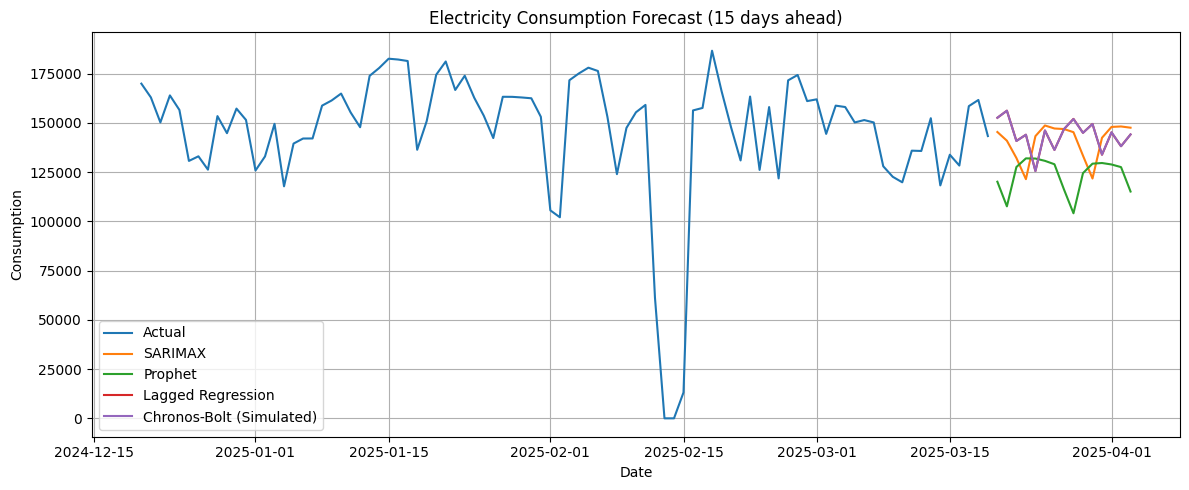

SARIMAX (15d): Not enough valid data for evaluation.
Prophet (15d): Not enough valid data for evaluation.
LagReg (15d): Not enough valid data for evaluation.
Chronos (15d): Not enough valid data for evaluation.


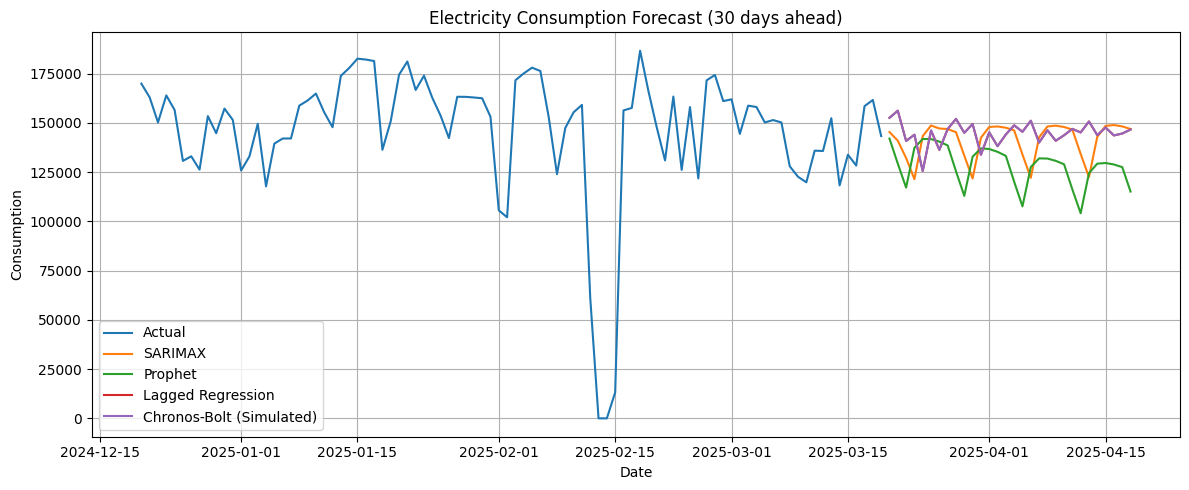

SARIMAX (30d): Not enough valid data for evaluation.
Prophet (30d): Not enough valid data for evaluation.
LagReg (30d): Not enough valid data for evaluation.
Chronos (30d): Not enough valid data for evaluation.


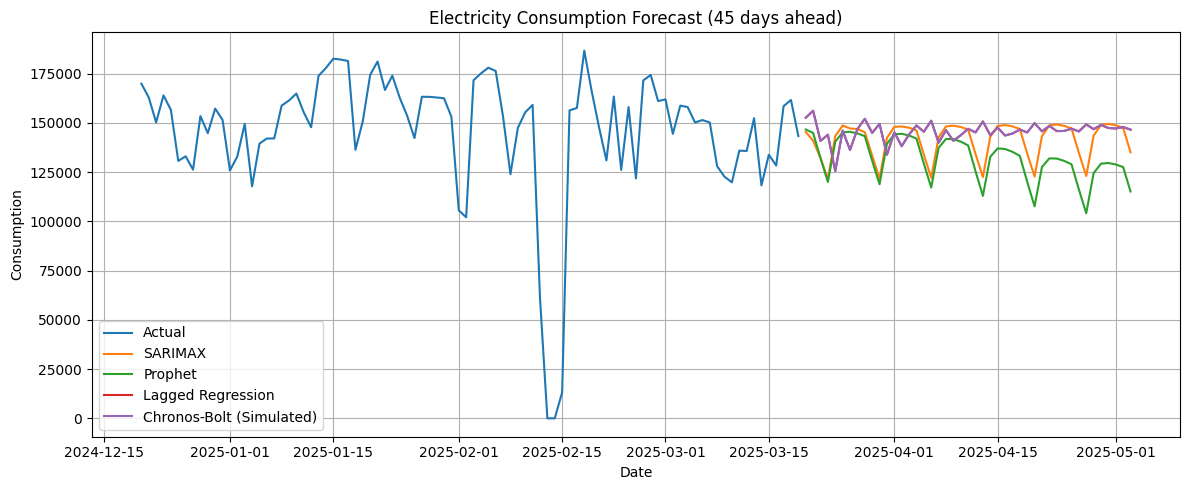

SARIMAX (45d): Not enough valid data for evaluation.
Prophet (45d): Not enough valid data for evaluation.
LagReg (45d): Not enough valid data for evaluation.
Chronos (45d): Not enough valid data for evaluation.


In [29]:
for horizon in forecast_days:
    plt.figure(figsize=(12, 5))
    plt.plot(daily_df[-90:], label='Actual')
    plt.plot(results_sarimax[horizon], label='SARIMAX')
    plt.plot(results_prophet[horizon], label='Prophet')
    plt.plot(results_lr[horizon], label='Lagged Regression')
    plt.plot(results_chronos[horizon], label='Chronos-Bolt (Simulated)')
    plt.title(f'Electricity Consumption Forecast ({horizon} days ahead)')
    plt.xlabel('Date')
    plt.ylabel('Consumption')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    actual = daily_df[-(horizon + 7):-7].copy().squeeze()
    for name, result in zip(['SARIMAX', 'Prophet', 'LagReg', 'Chronos'],
                            [results_sarimax[horizon], results_prophet[horizon],
                             results_lr[horizon], results_chronos[horizon]]):
        pred = result[:len(actual)]

        common_idx = actual.index.intersection(pred.index)
        df_eval = pd.DataFrame({
            'actual': actual.loc[common_idx],
            'pred': pred.loc[common_idx]
        }).dropna()

        if df_eval.empty:
            print(f'{name} ({horizon}d): Not enough valid data for evaluation.')
            continue
        mae = mean_absolute_error(df_eval['actual'], df_eval['pred'])
        rmse = np.sqrt(mean_squared_error(df_eval['actual'], df_eval['pred']))
        print(f'{name} ({horizon}d): MAE={mae:.2f}, RMSE={rmse:.2f}')